In [2]:
import sys
import os


sys.path.append(os.path.abspath("/Users/monika/Desktop/DP/DP_QSAR_Skin_Irritation"))
from imports import *
from sklearn.feature_selection import RFE

In [200]:
file_path = 'Datasets/rabbit_balanced.xlsx'
df = pd.read_excel(file_path)
df.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Irritation
0,0.115475,0.115577,0.324234,0.306088,0.566473,0.398167,0.189110,0.165640,0.189062,0.247074,...,0.0,0,0.0,0,0.0,0,0.0,0.277350,0.0,1
1,0.437912,0.438064,0.106913,0.240292,0.439388,0.384900,0.215185,0.199574,0.215150,0.263228,...,0.0,0,0.0,0,0.0,0,0.0,0.160128,0.0,1
2,0.837558,0.837621,0.114306,0.095302,0.333101,0.487005,0.558408,0.554732,0.558432,0.557971,...,0.0,0,0.0,0,0.0,0,0.0,0.000000,0.0,0
3,0.763428,0.763515,0.052517,0.206434,0.966983,0.515347,0.432265,0.431023,0.432268,0.440488,...,0.0,0,0.0,0,0.0,0,0.0,0.000000,0.0,0
4,0.603491,0.603619,0.132058,0.210742,0.898095,0.495430,0.476004,0.473851,0.475011,0.451594,...,0.0,0,0.0,0,0.0,0,0.0,0.000000,1.0,0


In [400]:
file_path = 'Features/Rabbit_B_SHAP_SVM.xlsx'
df = pd.read_excel(file_path)
df.head()

,PEOE_VSA11,EState_VSA2,VSA_EState6,SMR_VSA6,SMR_VSA10,PEOE_VSA9,fr_NH1,fr_amide,Irritation
0,0.000000,0.000000,0.000000,0.216018,0.000000,0.000000,0.000000,0.000000,1
1,0.000000,0.256312,0.000000,0.225150,0.208314,0.230156,0.000000,0.000000,1
2,0.680370,0.456627,0.403000,0.217041,0.292175,0.361580,0.408248,0.408248,0
3,0.392847,0.508912,0.282099,0.373221,0.290325,0.385121,0.408248,0.408248,0
4,0.000000,0.448460,0.226058,0.285657,0.583650,0.205850,0.408248,0.912871,0


In [343]:
file_path = 'Features/rabbit_b_corrvar.xlsx'
df = pd.read_excel(file_path)
df.head()

,MaxAbsEStateIndex,qed,SPS,MolWt,FpDensityMorgan1,AvgIpc,BalabanJ,Kappa2,PEOE_VSA1,PEOE_VSA10,...,fr_ketone_Topliss,fr_methoxy,fr_nitro,fr_para_hydroxylation,fr_pyridine,fr_sulfide,fr_sulfonamd,fr_unbrch_alkane,fr_urea,Irritation
0,0.115475,0.566473,0.398167,0.189110,0.450980,0.452681,0.362546,0.296615,0.196324,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.277350,0.0,1
1,0.437912,0.439388,0.384900,0.215185,0.694989,0.471835,0.426026,0.255578,0.178444,0.000000,...,0.0,0.500000,0.0,0.000000,0.0,0.0,0.0,0.160128,0.0,1
2,0.837558,0.333101,0.487005,0.558408,0.507776,0.868672,0.276277,0.340830,0.261267,0.212367,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0
3,0.763428,0.966983,0.515347,0.432265,0.529412,0.710703,0.305728,0.234571,0.315318,0.283030,...,0.0,0.707107,0.0,0.353553,0.0,0.0,0.0,0.000000,0.0,0
4,0.603491,0.898095,0.495430,0.476004,0.555556,0.656392,0.326643,0.265235,0.189052,0.211366,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,1.0,0


In [401]:
# Define features (X) and target variable (y)
X = df.drop(columns=['Irritation']) 
y = df['Irritation']

In [387]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Print the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (685, 21)
Shape of X_test: (172, 21)
Shape of y_train: (685,)
Shape of y_test: (172,)


In [196]:
file_path = 'Datasets/cleaned_df_test.xlsx'
df2 = pd.read_excel(file_path)
df2.shape

(259, 203)

In [111]:
df2 = df2[df.columns]  

In [112]:
df2.to_excel("Features/selected_features_CorrVar_test.xlsx", index=False)

## Correlation + Variation

In [47]:
def feature_selection(df):
    nonzero_thrd=0.015
    cor_thrd=0.85
    print(f"Original shape of data: {df.shape}")
   
    #Remove features with low variance
    nonzero_df = df.loc[:, df.var() > nonzero_thrd]
    print(f"Removed {df.shape[1] - nonzero_df.shape[1]} features with variance <= {nonzero_thrd}")
    
    #Remove highly correlated features
    corr_matrix = nonzero_df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > cor_thrd)]
    print(f"Removed {len(to_drop)} highly correlated features with correlation > {cor_thrd}")
    
    #Return the cleaned dataset
    cleaned_df = nonzero_df.drop(to_drop, axis=1)
    print(f"Final shape of data: {cleaned_df.shape}")
    return cleaned_df


df_cleaned = feature_selection(df)
df = feature_selection(df)
CorrVar_selected_features = list(df_cleaned.columns)

Original shape of data: (857, 115)
Removed 16 features with variance <= 0.015
Removed 5 highly correlated features with correlation > 0.85
Final shape of data: (857, 94)
Original shape of data: (857, 115)
Removed 16 features with variance <= 0.015
Removed 5 highly correlated features with correlation > 0.85
Final shape of data: (857, 94)


In [48]:
# Convert to DataFrame
df_selected = df[CorrVar_selected_features]

# Export to Excel
df_selected.to_excel("Features/rabbit_b_corrvar.xlsx", index=False)

## Lasso

In [201]:
# Train a Lasso model
lasso = Lasso(alpha=0.005)
lasso.fit(X, y)

# Get important features (non-zero coefficients)
important_features = X.columns[np.abs(lasso.coef_) > 0]
print("Selected Features:", important_features)



Selected Features: Index(['MaxEStateIndex', 'qed', 'AvgIpc', 'BertzCT', 'Chi4n', 'PEOE_VSA1',
       'PEOE_VSA11', 'PEOE_VSA3', 'PEOE_VSA6', 'PEOE_VSA9', 'SMR_VSA6',
       'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'VSA_EState2',
       'VSA_EState4', 'VSA_EState6', 'NumHeteroatoms', 'fr_NH1', 'fr_NH2',
       'fr_amide'],
      dtype='object')


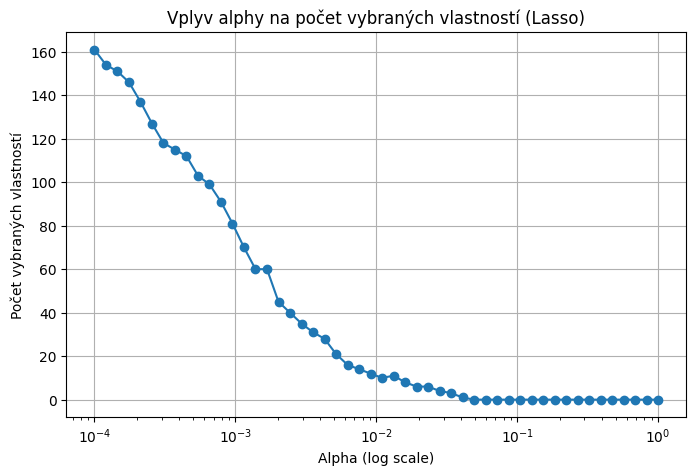

In [205]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso

#alpha values for testing
alphas = np.logspace(-4, 0, 50) 

selected_features_counts = []

#for every alpha value train lasso model
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X, y)
    important_features = X.columns[np.abs(lasso.coef_) > 0]
    selected_features_counts.append(len(important_features)) 

    
#Ploting how aloha values changes accuracy 
plt.figure(figsize=(8, 5))
plt.plot(alphas, selected_features_counts, marker='o')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Počet vybraných vlastností')
plt.title('Vplyv alphy na počet vybraných vlastností (Lasso)')
plt.grid(True)
plt.show()


In [219]:
#testing alpha values 
alphas = np.logspace(-4, 0, 50)

# Save number of selected features and results for every model 
selected_features_counts = {  'XGBoost': [], 'DecisionTree': [], 'RandomForest': [], 'SVM': [], 'KNN': [] }
accuracies = {  'XGBoost': [], 'DecisionTree': [], 'RandomForest': [], 'SVM': [], 'KNN': [] }

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#Try every alpha value 
for alpha in alphas:
    # Lasso model
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train, y_train)
    
    # get important features 
    important_features = X.columns[np.abs(lasso.coef_) > 0]
    
    # Test if the features exist in X train and test
    X_train_lasso = X_train[important_features]
    X_test_lasso = X_test[important_features] 

    if X_train_lasso.shape[1] == 0:
        #print at the end, when there are no more features to select 
        print("No important features selected. Consider adjusting alpha.")
        break

    
    # XGBoost model
    xgb = XGBClassifier()
    xgb.fit(X_train_lasso, y_train)
    y_pred_xgb = xgb.predict(X_test_lasso)
    accuracies['XGBoost'].append(accuracy_score(y_test, y_pred_xgb))
    selected_features_counts['XGBoost'].append(len(important_features))
    
    # Decision Tree model
    tree = DecisionTreeClassifier()
    tree.fit(X_train_lasso, y_train)
    y_pred_tree = tree.predict(X_test_lasso)
    accuracies['DecisionTree'].append(accuracy_score(y_test, y_pred_tree))
    selected_features_counts['DecisionTree'].append(len(important_features))
    
    # Random Forest model
    rf = RandomForestClassifier()
    rf.fit(X_train_lasso, y_train)
    y_pred_rf = rf.predict(X_test_lasso)
    accuracies['RandomForest'].append(accuracy_score(y_test, y_pred_rf))
    selected_features_counts['RandomForest'].append(len(important_features))
    
    # SVM model
    svm = SVC()
    svm.fit(X_train_lasso, y_train)
    y_pred_svm = svm.predict(X_test_lasso)
    accuracies['SVM'].append(accuracy_score(y_test, y_pred_svm))
    selected_features_counts['SVM'].append(len(important_features))
    
    # KNN model
    knn = KNeighborsClassifier()
    knn.fit(X_train_lasso, y_train)
    y_pred_knn = knn.predict(X_test_lasso)
    accuracies['KNN'].append(accuracy_score(y_test, y_pred_knn))
    selected_features_counts['KNN'].append(len(important_features))


No important features selected. Consider adjusting alpha.


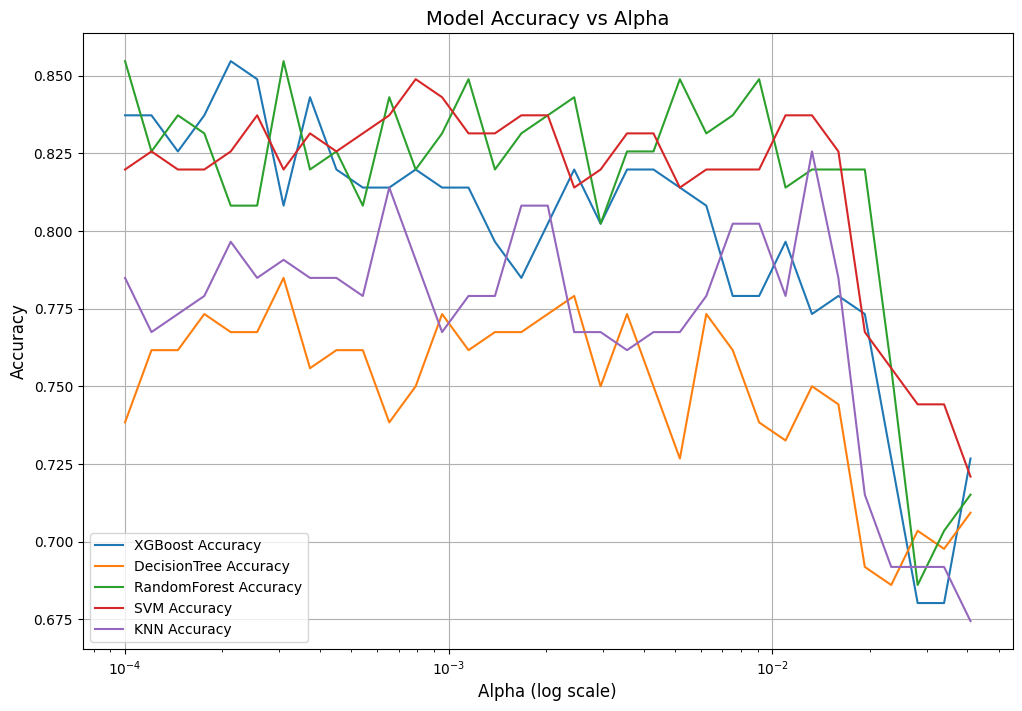

In [218]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for model in selected_features_counts:
    valid_alphas = []
    valid_accuracies = []
    
    for i, alpha in enumerate(alphas):
        if i < len(accuracies[model]) and accuracies[model][i] is not None:
            valid_alphas.append(alpha)
            valid_accuracies.append(accuracies[model][i])
    
    # plot accuracy for every model 
    plt.plot(valid_alphas, valid_accuracies, label=f'{model} Accuracy')


plt.xscale('log')

#axis 
plt.xlabel('Alpha (log scale)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Model Accuracy vs Alpha', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


In [202]:
feature_names_Lasso = list(important_features.values)

In [ ]:
selected_features = feature_names_Lasso
selected_features.append("Irritation")

# Convert to DataFrame
df_selected = df[selected_features]

# Export to Excel
df_selected.to_excel("Features/Rabbit_LAsso.xlsx", index=False)

In [203]:
feature_names_Lasso

['MaxEStateIndex',
 'qed',
 'AvgIpc',
 'BertzCT',
 'Chi4n',
 'PEOE_VSA1',
 'PEOE_VSA11',
 'PEOE_VSA3',
 'PEOE_VSA6',
 'PEOE_VSA9',
 'SMR_VSA6',
 'EState_VSA2',
 'EState_VSA3',
 'EState_VSA4',
 'VSA_EState2',
 'VSA_EState4',
 'VSA_EState6',
 'NumHeteroatoms',
 'fr_NH1',
 'fr_NH2',
 'fr_amide']

In [204]:
selected_features = feature_names_Lasso
selected_features.append("Irritation")

# Convert to DataFrame
df_selected = df[selected_features]

# Export to Excel
df_selected.to_excel("Features/Rabbit_LAsso.xlsx", index=False)

## Models

In [321]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [314]:
def xgboost(X_train, y_train, X_test, y_test):
    # Instantiate the XGBoost classifier
    xgb_model = XGBClassifier(objective='binary:logistic')

    # Perform cross-validation with 5 folds and accuracy scoring
    cv_results = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy')

    # Print cross-validation results
    print("Cross-validation results:")
    print(cv_results)
    print("Average Accuracy:", cv_results.mean())

    # Fit the model on the entire training dataset
    xgb_model.fit(X_train, y_train)

    # Evaluate accuracy on test data
    test_accuracy = xgb_model.score(X_test, y_test)
    train_accuracy = xgb_model.score(X_train, y_train)
    print("Train Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)

    y_pred_test = xgb_model.predict(X_test)
    # Precision, Recall, F1-score (binary classification)
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    return xgb_model

In [315]:
def random_forest(X_train, y_train, X_test, y_test):
    # Initialize the RandomForestClassifier
    rf = RandomForestClassifier()

    # Cross-validation
    cv_results = cross_val_score(rf, X_train, y_train, cv=5)

    # Fit the model to the training data
    rf.fit(X_train, y_train)

    # Predict on the test set
    y_pred_test = rf.predict(X_test)
    y_pred_train = rf.predict(X_train)

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test, y_pred_test)
    train_accuracy = accuracy_score(y_train, y_pred_train)

    # Print the results
    print("Cross-validation results:", cv_results)
    print(f"Average Accuracy: {np.mean(cv_results)}")
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")


    y_pred_test = rf.predict(X_test)
    # Precision, Recall, F1-score (binary classification)
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    return rf

In [316]:
def decision_tree(X_train, y_train, X_test, y_test):
    dt = DecisionTreeClassifier()
    
    # Cross-validation
    cv_results = cross_val_score(dt, X_train, y_train, cv = 5)
    dt.fit(X_train, y_train)

    # Predict on the test set
    y_pred_test = dt.predict(X_test)
    y_pred_train = dt.predict(X_train)

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test, y_pred_test)
    train_accuracy = accuracy_score(y_train, y_pred_train)

    # Print the results
    print("Cross-validation results:", cv_results)
    print(f"Average Accuracy: {np.mean(cv_results)}")
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")

    y_pred_test = dt.predict(X_test)
    # Precision, Recall, F1-score (binary classification)
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    return dt
    

In [318]:
def k_neigbhors(X_train, y_train, X_test, y_test):
    knn = KNeighborsClassifier()

    cv_results = cross_val_score(knn, X_train, y_train, cv=5)
    knn.fit(X_train, y_train)

    # Predict on the test set
    y_pred_test = knn.predict(X_test)
    y_pred_train = knn.predict(X_train)

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test, y_pred_test)
    train_accuracy = accuracy_score(y_train, y_pred_train)

    # Print the results
    print("Cross-validation results:", cv_results)
    print(f"Average Accuracy: {np.mean(cv_results)}")
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")

    y_pred_test = knn.predict(X_test)
    # Precision, Recall, F1-score (binary classification)
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    return knn

In [319]:
def Support_vector_machine(X_train, y_train, X_test, y_test):
    svm= SVC(probability=True, kernel="linear", C=1)

    cv_results = cross_val_score(svm, X_train, y_train, cv=5)
    svm.fit(X_train, y_train)

    # Predict on the test set
    y_pred_test = svm.predict(X_test)
    y_pred_train = svm.predict(X_train)

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test, y_pred_test)
    train_accuracy = accuracy_score(y_train, y_pred_train)

    # Print the results
    print("Cross-validation results:", cv_results)
    print(f"Average Accuracy: {np.mean(cv_results)}")
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")


    y_pred_test = svm.predict(X_test)
    # Precision, Recall, F1-score (binary classification)
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    return svm

In [404]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Print the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (685, 8)
Shape of X_test: (172, 8)
Shape of y_train: (685,)
Shape of y_test: (172,)


In [406]:
print("XGBoost:")
xgb_model = xgboost(X_train, y_train, X_test, y_test)
print("\nRandom forest:")
rf_model = random_forest(X_train, y_train, X_test, y_test)
print("\nDecision tree:")
dt_model = decision_tree(X_train, y_train, X_test, y_test)
print("\nKNN:")
knn_model = k_neigbhors(X_train, y_train, X_test, y_test)
print("\nSVM")
svm_model = Support_vector_machine(X_train, y_train, X_test, y_test)

XGBoost:

Random forest:

Decision tree:

KNN:
Cross-validation results: [0.74452555 0.83211679 0.73722628 0.81751825 0.68613139]
Average Accuracy: 0.7635036496350365
Train Accuracy: 0.8116788321167884
Test Accuracy: 0.7151162790697675
Precision: 0.6575342465753424
Recall: 0.6666666666666666
F1 Score: 0.6620689655172414

SVM
Cross-validation results: [0.73722628 0.84671533 0.73722628 0.82481752 0.72992701]
Average Accuracy: 0.7751824817518249
Train Accuracy: 0.7897810218978102
Test Accuracy: 0.7732558139534884
Precision: 0.7088607594936709
Recall: 0.7777777777777778
F1 Score: 0.7417218543046358


## SHAP Feature Selection

In [407]:
def xgboost_sort_features(model, X_train):
     # Create SHAP explainer and calculate SHAP values
    explainer = shap.Explainer(model)
    shap_values = explainer.shap_values(X_train)

    # Calculate feature importance (mean absolute SHAP values)
    feature_importance = np.abs(shap_values).mean(0)

    # Sort features by importance
    sorted_idx = np.argsort(feature_importance)[::-1]  # Sort in descending order of importance
    return sorted_idx

In [58]:
def tree_sort_features(model, X_train):       
    #  Create SHAP explainer for Random Forest
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)  # Shape: (samples, features, 2)

    # Compute SHAP difference (Class 1 - Class 0) and take mean absolute values
    shap_values_diff = shap_values[:, :, 1] - shap_values[:, :, 0]
    feature_importance = np.abs(shap_values_diff).mean(axis=0)  # Shape: (features,)

    # Sort features by importance
    sorted_idx = np.argsort(feature_importance)[::-1]
    return sorted_idx

In [112]:
def kernel_sort_features(model, X_train):
    # Use smaller sample for background
    background = X_train.sample(20)
    explainer = shap.KernelExplainer(model.predict, background)
    
    # Compute SHAP on a sample, limit nsamples
    X_sample = X_train.sample(100)
    shap_values = explainer.shap_values(X_sample, nsamples=100)
    
    shap_values = np.array(shap_values)
    feature_importance = np.abs(shap_values).mean(axis=0)
    sorted_idx = np.argsort(feature_importance)[::-1]
    return sorted_idx


In [167]:
SHAP_Feature_selection = []

In [166]:
def find_best_num_features(X_train, y_train, X_test, y_test, model, max_features=100):
    #sorted_idx = xgboost_sort_features(model, X_train)
    #sorted_idx = tree_sort_features(model, X_train)
    sorted_idx = kernel_sort_features(model, X_train)
    
    validation_accuracies = []
    train_accuracies = []

    for num_features in range(1, max_features + 1):
        selected_features = X_train.columns[sorted_idx[:num_features]]
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]

        # Clone the model to prevent modifying the original instance
        model_copy = clone(model)
        model_copy.fit(X_train_selected, y_train)

        y_pred = model_copy.predict(X_test_selected)
        y_pred_train = model_copy.predict(X_train_selected)
        accuracy = accuracy_score(y_test, y_pred)
        train_accuracy = accuracy_score(y_train, y_pred_train)
        validation_accuracies.append(accuracy)
        train_accuracies.append(train_accuracy)

    plt.plot(range(1, max_features + 1), validation_accuracies, marker='o')
    #plt.plot(range(1, max_features + 1), train_accuracies, marker='o', color = "red")
    plt.xlabel("Number of Features")
    plt.ylabel("Validation Accuracy")
    plt.title("Validation Accuracy vs. Number of Features")
    plt.show()

    optimal_num_features = np.argmax(validation_accuracies) + 1
    print(f"Optimal number of features: {optimal_num_features}")

    selected_features = X_train.columns[sorted_idx[:optimal_num_features]]
    X_train_optimal = X_train[selected_features]
    X_test_optimal = X_test[selected_features]

    return X_train_optimal, X_test_optimal

In [270]:
def full_feature_analysis(X_train, y_train, X_test, y_test, model, max_features=100):
    #sorted_idx = xgboost_sort_features(model, X_train)
    #sorted_idx = tree_sort_features(model, X_train)
    sorted_idx = kernel_sort_features(model, X_train)

    validation_accuracies = []
    validation_precisions = []
    validation_recalls = []

    feature_counts = list(range(1, max_features + 1))

    for num_features in feature_counts:
        selected_features = X_train.columns[sorted_idx[:num_features]]
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]

        model_copy = clone(model)
        model_copy.fit(X_train_selected, y_train)

        y_pred = model_copy.predict(X_test_selected)

        validation_accuracies.append(accuracy_score(y_test, y_pred))
        validation_precisions.append(precision_score(y_test, y_pred))
        validation_recalls.append(recall_score(y_test, y_pred))

    #Plot 1: Accuracy, Precision, and Recall
    plt.figure(figsize=(10, 6))
    plt.plot(feature_counts, validation_accuracies, label='Presnosť', marker='o')
    plt.plot(feature_counts, validation_precisions, label='Precíznosť', marker='x')
    plt.plot(feature_counts, validation_recalls, label='Citlivosť', marker='s')
    plt.xlabel('Počet deskriptorov')
    plt.ylabel('Skóre')
    plt.title('Metriky pri rôznych počtoch deskriptorov')
    plt.legend()
    plt.grid(True)
    plt.show()

    #Plot 2 ROC Curves for selected feature counts
    selected_feature_counts = [10, 20, 50, 75, 100]
    plt.figure(figsize=(10, 8))

    for num_features in selected_feature_counts:
        selected_features = X_train.columns[sorted_idx[:num_features]]
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]

        model_copy = clone(model)
        model_copy.fit(X_train_selected, y_train)

        y_proba = model_copy.predict_proba(X_test_selected)[:, 1]

        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'{num_features} deskriptory (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Náhodný tip')
    plt.xlabel('Miera falošne pozitívnych')
    plt.ylabel('Miera skutočne pozitívnych')
    plt.title('ROC krivky pre rôzne počty deskriptorov')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


Cross-validation results: [0.76642336 0.79562044 0.79562044 0.81021898 0.77372263]
Average Accuracy: 0.7883211678832117
Train Accuracy: 0.8832116788321168
Test Accuracy: 0.75


  0%|          | 0/100 [00:00<?, ?it/s]

/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 48 iterations, i.e. alpha=1.041e-03, with an active set of 36 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 49 iterations, i.e. alpha=1.035e-03, with an active set of 37 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 50 iterations, i.e. alpha=9.758e-04, with an active set of 38

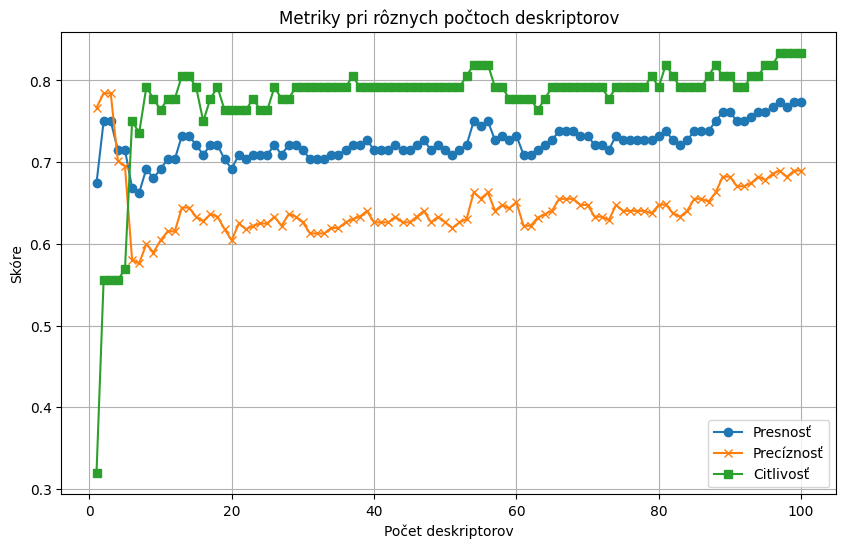

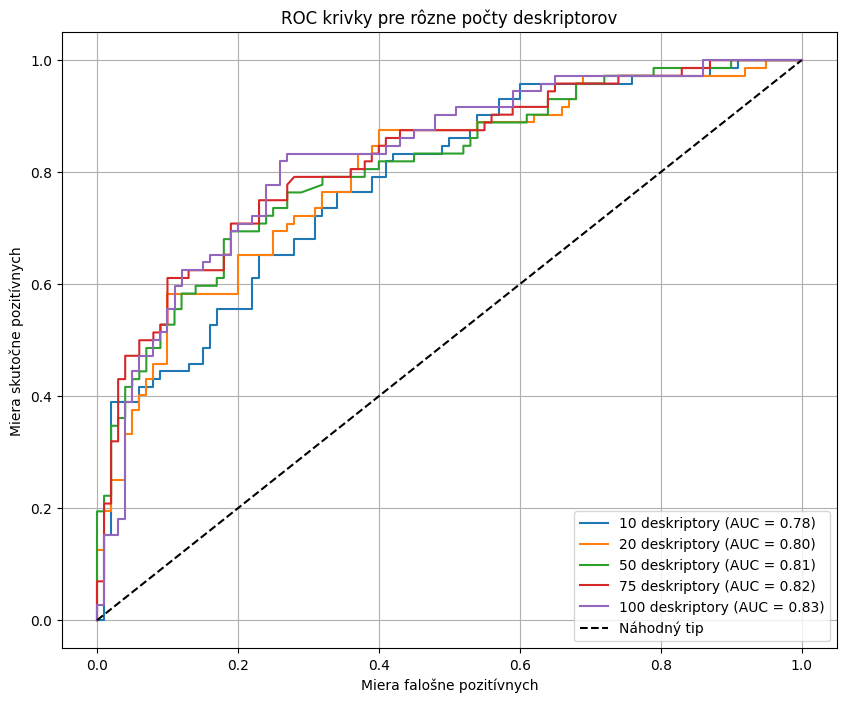

TypeError: cannot unpack non-iterable NoneType object

In [292]:

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
rf_model = Support_vector_machine(X_train, y_train, X_test, y_test)

X_train_selected, X_test_selected = full_feature_analysis(X_train, y_train, X_test, y_test, rf_model)

1
Cross-validation results: [0.82105263 0.8245614  0.83859649 0.82807018 0.8415493 ]
Average Accuracy: 0.8307659995058068
Train Accuracy: 0.8876404494382022
Test Accuracy: 0.8651685393258427


  0%|          | 0/100 [00:00<?, ?it/s]

/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=4.777e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:718: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 122 iterations, alpha=1.246e-03, previous alpha=1.246e-03, with an active set of 31 regressors.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:718: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 62 iterations, alpha=2.081e-04, prev

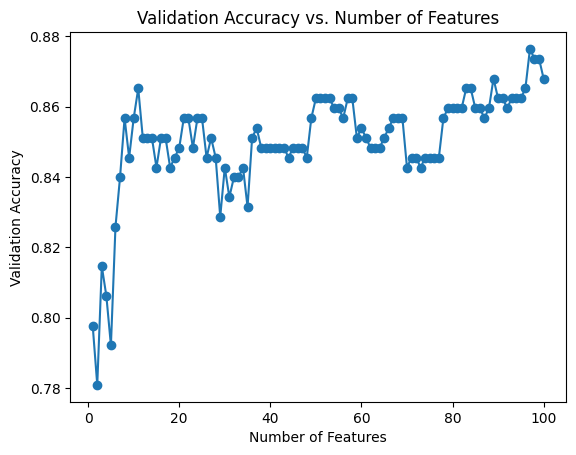

Optimal number of features: 97
2
Cross-validation results: [0.84912281 0.84561404 0.83157895 0.85263158 0.84859155]
Average Accuracy: 0.8455077835433654
Train Accuracy: 0.8967696629213483
Test Accuracy: 0.8426966292134831


  0%|          | 0/100 [00:00<?, ?it/s]

/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.382e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:718: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 52 iterations, alpha=2.725e-02, previous alpha=2.677e-02, with an active set of 21 regressors.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 78 iterations, i.e. alpha=2.353e-04, with an active set of 32 regressors, and the smallest 

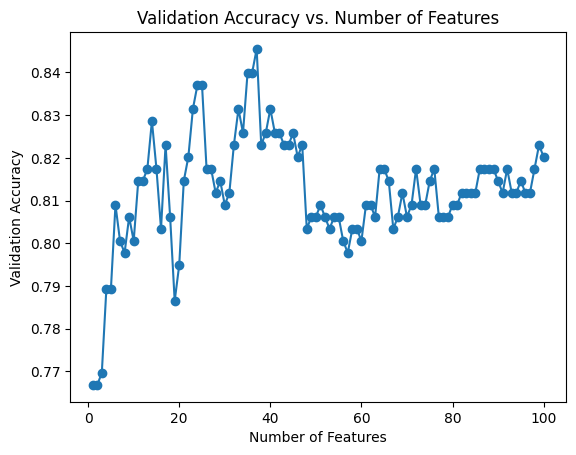

Optimal number of features: 37
3
Cross-validation results: [0.82105263 0.86315789 0.86315789 0.83859649 0.85211268]
Average Accuracy: 0.8476155176674081
Train Accuracy: 0.8960674157303371
Test Accuracy: 0.8117977528089888


  0%|          | 0/100 [00:00<?, ?it/s]

/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:718: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 49 iterations, alpha=5.461e-04, previous alpha=5.444e-04, with an active set of 30 regressors.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=3.728e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:718: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 13 iterations, alpha=1.923e-02, previou

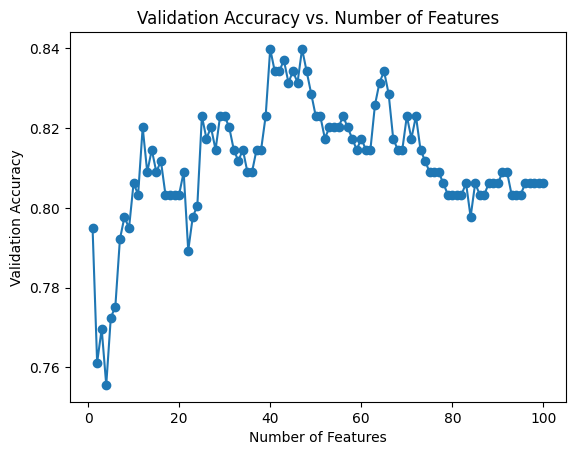

Optimal number of features: 40
4
Cross-validation results: [0.78947368 0.83508772 0.83859649 0.8245614  0.83098592]
Average Accuracy: 0.8237410427477144
Train Accuracy: 0.8862359550561798
Test Accuracy: 0.8735955056179775


  0%|          | 0/100 [00:00<?, ?it/s]

/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.759e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=4.243e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:718: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 91 iteratio

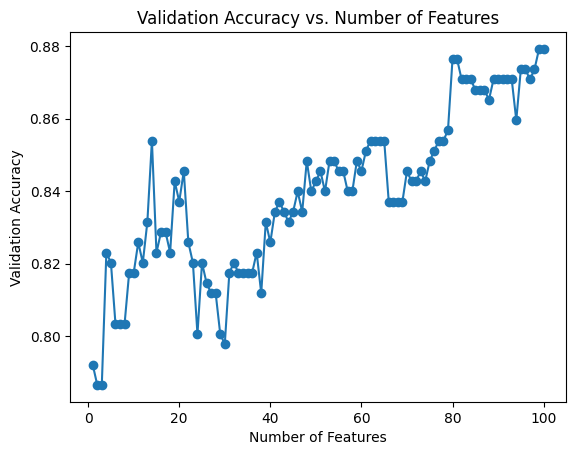

Optimal number of features: 99
5
Cross-validation results: [0.86315789 0.83157895 0.82807018 0.82105263 0.83802817]
Average Accuracy: 0.8363775636273783
Train Accuracy: 0.8953651685393258
Test Accuracy: 0.8342696629213483


  0%|          | 0/100 [00:00<?, ?it/s]

/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:718: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 69 iterations, alpha=4.014e-04, previous alpha=3.788e-04, with an active set of 40 regressors.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.606e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.398e-03, with an active set of 8 regressors, and the smallest ch

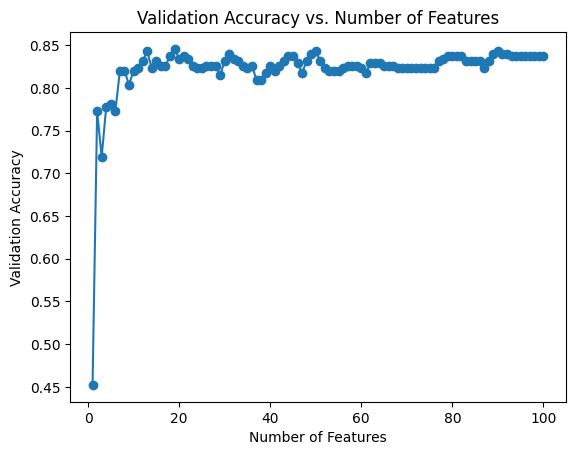

Optimal number of features: 19
6
Cross-validation results: [0.81754386 0.84561404 0.81403509 0.84210526 0.81690141]
Average Accuracy: 0.8272399308129478
Train Accuracy: 0.8792134831460674
Test Accuracy: 0.8735955056179775


  0%|          | 0/100 [00:00<?, ?it/s]

/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 83 iterations, i.e. alpha=8.300e-05, with an active set of 39 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:718: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 84 iterations, alpha=8.201e-05, previous alpha=8.140e-05, with an active set of 39 regressors.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/shap/explainers/_kernel.py:707: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the

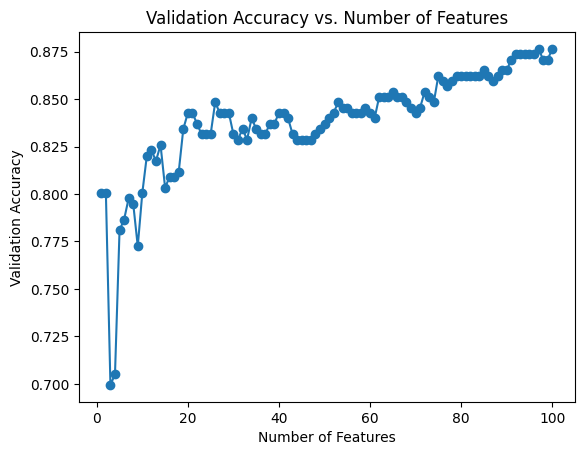

Optimal number of features: 97
7
Cross-validation results: [0.83859649 0.83859649 0.78947368 0.83859649 0.78873239]
Average Accuracy: 0.8187991104521869
Train Accuracy: 0.8918539325842697
Test Accuracy: 0.8539325842696629


  0%|          | 0/100 [00:00<?, ?it/s]

/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=2.035e-02, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:718: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 61 iterations, alpha=3.980e-03, previous alpha=3.969e-03, with an active set of 22 regressors.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:718: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 42 iterations, alpha=7.376e-04, previ

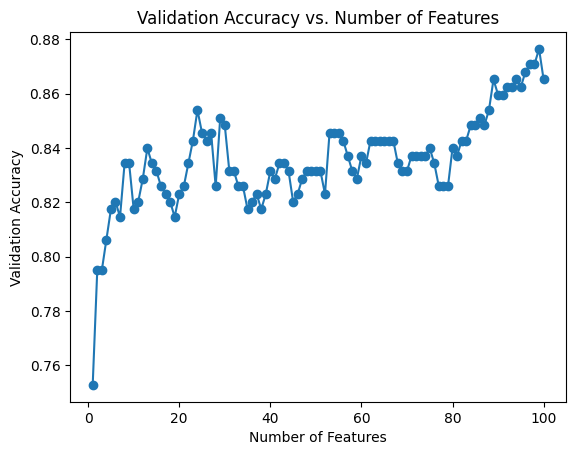

Optimal number of features: 99
8
Cross-validation results: [0.8        0.84210526 0.83508772 0.82807018 0.81338028]
Average Accuracy: 0.8237286879169755
Train Accuracy: 0.8904494382022472
Test Accuracy: 0.8202247191011236


  0%|          | 0/100 [00:00<?, ?it/s]

/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 65 iterations, i.e. alpha=5.255e-05, with an active set of 31 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 66 iterations, i.e. alpha=5.176e-05, with an active set of 32 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:718: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 67 iterat

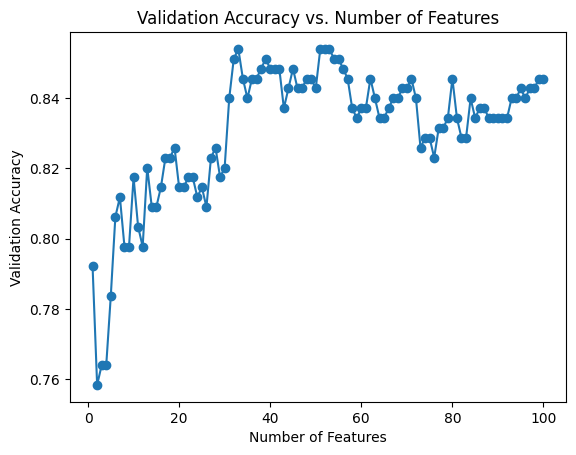

Optimal number of features: 33
9
Cross-validation results: [0.84912281 0.83157895 0.84912281 0.83859649 0.80633803]
Average Accuracy: 0.8349518161601186
Train Accuracy: 0.8911516853932584
Test Accuracy: 0.8314606741573034


  0%|          | 0/100 [00:00<?, ?it/s]

/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.208e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:718: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 63 iterations, alpha=4.981e-03, previous alpha=4.966e-03, with an active set of 20 regressors.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:718: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=1.088e-02, previou

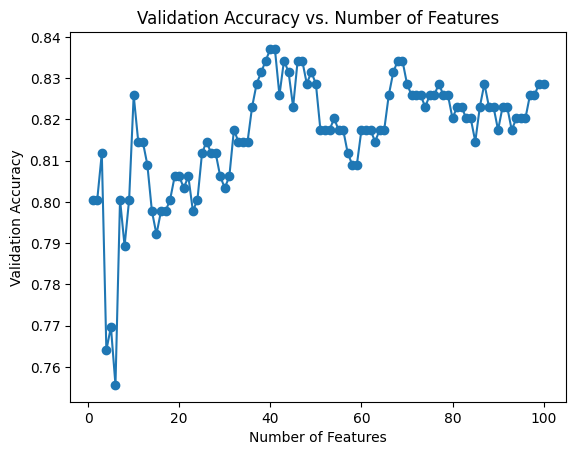

Optimal number of features: 40
10
Cross-validation results: [0.84561404 0.82105263 0.81754386 0.83859649 0.85915493]
Average Accuracy: 0.8363923894242647
Train Accuracy: 0.8890449438202247
Test Accuracy: 0.8651685393258427


  0%|          | 0/100 [00:00<?, ?it/s]

/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:718: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 79 iterations, alpha=8.548e-05, previous alpha=8.548e-05, with an active set of 38 regressors.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/shap/explainers/_kernel.py:707: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate. 

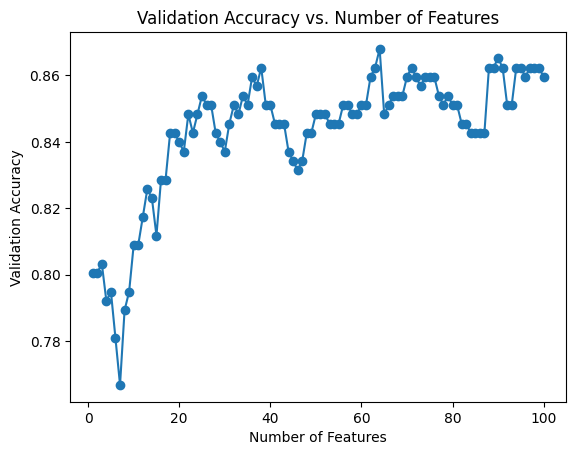

Optimal number of features: 64
11
Cross-validation results: [0.83508772 0.82105263 0.85263158 0.84912281 0.8556338 ]
Average Accuracy: 0.8427057079318013
Train Accuracy: 0.8946629213483146
Test Accuracy: 0.7949438202247191


  0%|          | 0/100 [00:00<?, ?it/s]

/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.142e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:718: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 129 iterations, alpha=4.252e-04, previous alpha=4.252e-04, with an active set of 30 regressors.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=1.326e-05, with an active set of 17 regressors, and the smallest

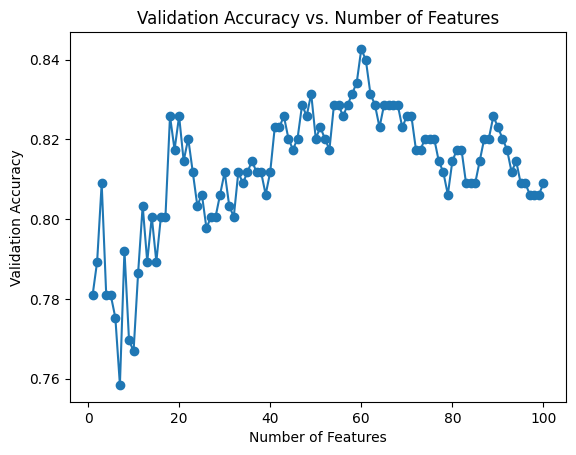

Optimal number of features: 60
12
Cross-validation results: [0.83859649 0.80701754 0.81403509 0.82807018 0.83098592]
Average Accuracy: 0.8237410427477144
Train Accuracy: 0.8911516853932584
Test Accuracy: 0.8539325842696629


  0%|          | 0/100 [00:00<?, ?it/s]

/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=7.199e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.823e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:718: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 16 iteration

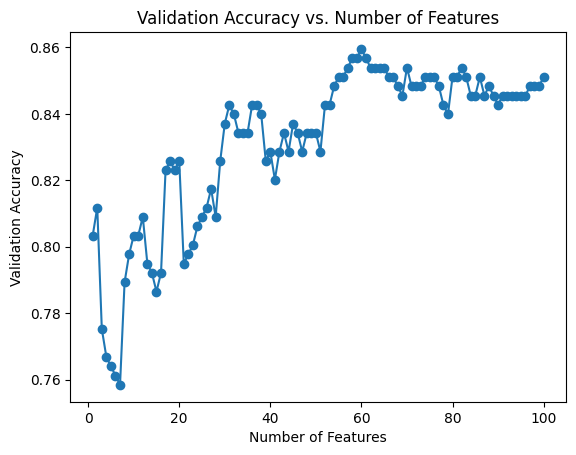

Optimal number of features: 60
13
Cross-validation results: [0.85614035 0.84210526 0.83508772 0.83508772 0.84507042]
Average Accuracy: 0.8426982950333579
Train Accuracy: 0.8953651685393258
Test Accuracy: 0.8314606741573034


  0%|          | 0/100 [00:00<?, ?it/s]

/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:718: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 103 iterations, alpha=5.913e-05, previous alpha=5.913e-05, with an active set of 38 regressors.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/shap/explainers/_kernel.py:707: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate.

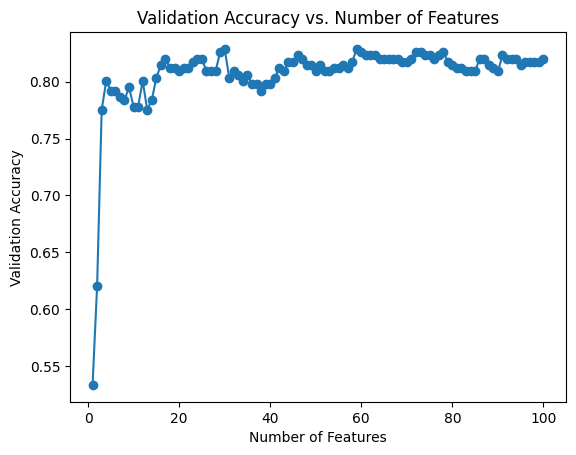

Optimal number of features: 30
14
Cross-validation results: [0.81754386 0.8245614  0.82105263 0.84561404 0.83802817]
Average Accuracy: 0.8293600197677293
Train Accuracy: 0.8890449438202247
Test Accuracy: 0.8539325842696629


  0%|          | 0/100 [00:00<?, ?it/s]

/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.617e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:718: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 109 iterations, alpha=4.401e-03, previous alpha=4.401e-03, with an active set of 40 regressors.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=7.706e-03, with an active set of 2 regressors, and the smallest c

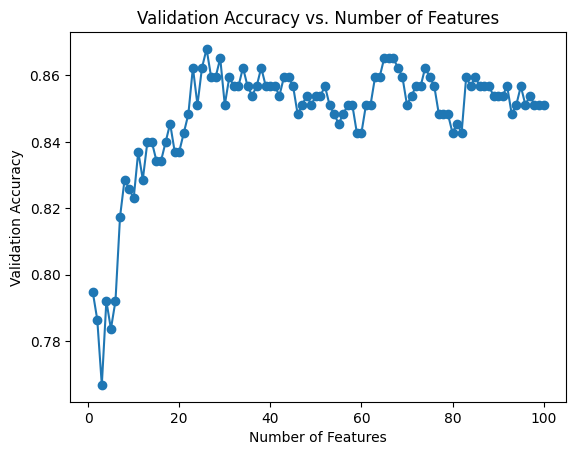

Optimal number of features: 26
15
Cross-validation results: [0.83508772 0.84561404 0.84912281 0.83859649 0.86971831]
Average Accuracy: 0.8476278724981468
Train Accuracy: 0.8946629213483146
Test Accuracy: 0.8174157303370787


  0%|          | 0/100 [00:00<?, ?it/s]

/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=8.480e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:718: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 62 iterations, alpha=1.989e-03, previous alpha=1.988e-03, with an active set of 31 regressors.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:718: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 34 iterations, alpha=1.266e-03, previou

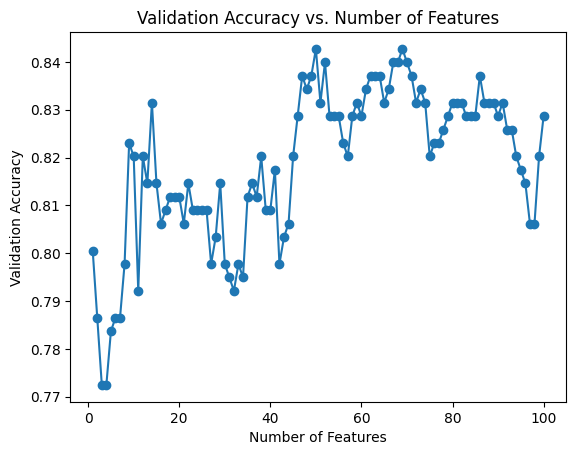

Optimal number of features: 50
16
Cross-validation results: [0.84210526 0.82807018 0.83157895 0.84561404 0.83098592]
Average Accuracy: 0.8356708673091179
Train Accuracy: 0.8890449438202247
Test Accuracy: 0.8342696629213483


  0%|          | 0/100 [00:00<?, ?it/s]

/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=5.720e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:718: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 44 iterations, alpha=2.385e-04, previous alpha=2.385e-04, with an active set of 31 regressors.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.241e-01, with an active set of 3 regressors, and the smallest 

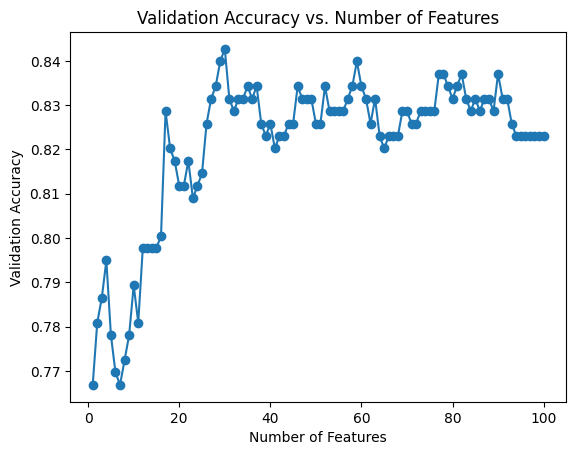

Optimal number of features: 30
17
Cross-validation results: [0.84561404 0.79649123 0.86666667 0.83508772 0.84859155]
Average Accuracy: 0.8384902396837164
Train Accuracy: 0.8974719101123596
Test Accuracy: 0.8202247191011236


  0%|          | 0/100 [00:00<?, ?it/s]

/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.694e-01, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:718: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 94 iterations, alpha=3.360e-02, previous alpha=3.350e-02, with an active set of 43 regressors.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:718: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 118 iterations, alpha=3.786e-04, previo

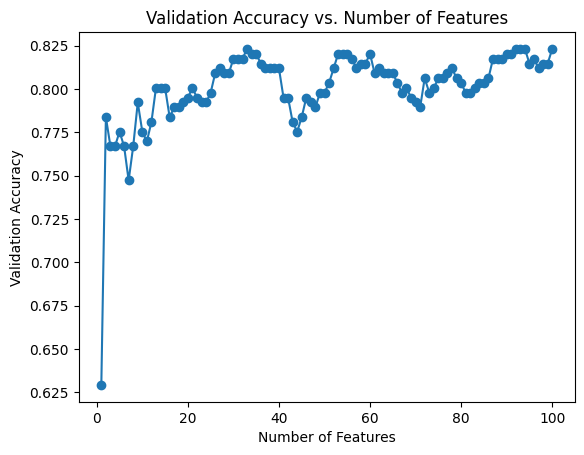

Optimal number of features: 33
18
Cross-validation results: [0.84210526 0.84561404 0.84210526 0.83157895 0.83802817]
Average Accuracy: 0.8398863355572029
Train Accuracy: 0.8939606741573034
Test Accuracy: 0.8286516853932584


  0%|          | 0/100 [00:00<?, ?it/s]

/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:718: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 45 iterations, alpha=5.757e-03, previous alpha=5.676e-03, with an active set of 34 regressors.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=6.354e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:718: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 85 iterations, alpha=1.281e-03, previou

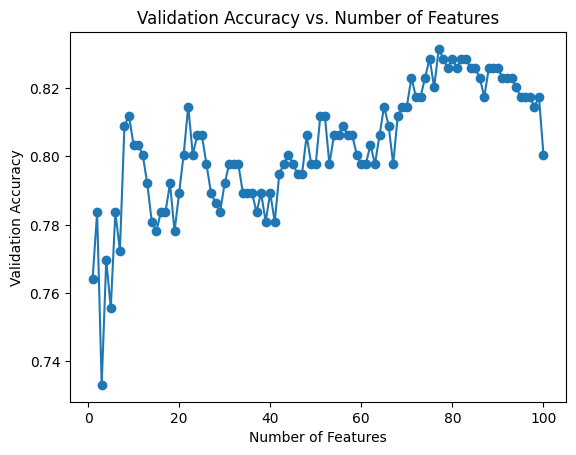

Optimal number of features: 77
19
Cross-validation results: [0.81052632 0.84912281 0.80350877 0.85263158 0.86619718]
Average Accuracy: 0.8363973313565604
Train Accuracy: 0.8827247191011236
Test Accuracy: 0.8679775280898876


  0%|          | 0/100 [00:00<?, ?it/s]

/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:718: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 106 iterations, alpha=5.976e-04, previous alpha=5.976e-04, with an active set of 41 regressors.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/shap/explainers/_kernel.py:707: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate.

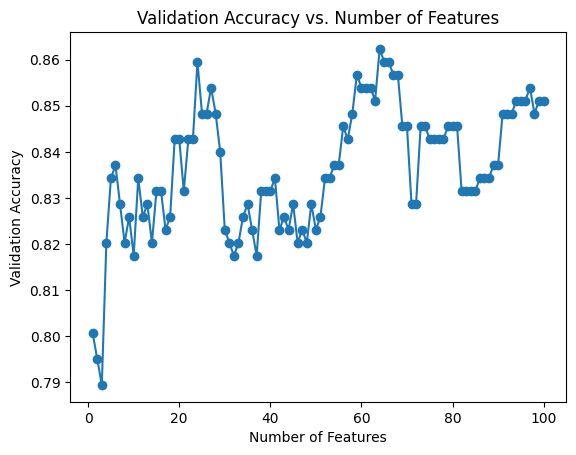

Optimal number of features: 64
20
Cross-validation results: [0.85614035 0.81754386 0.83859649 0.86666667 0.83098592]
Average Accuracy: 0.841986656782802
Train Accuracy: 0.8904494382022472
Test Accuracy: 0.8146067415730337


  0%|          | 0/100 [00:00<?, ?it/s]

/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=3.403e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.701e-02, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:718: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 18 iteratio

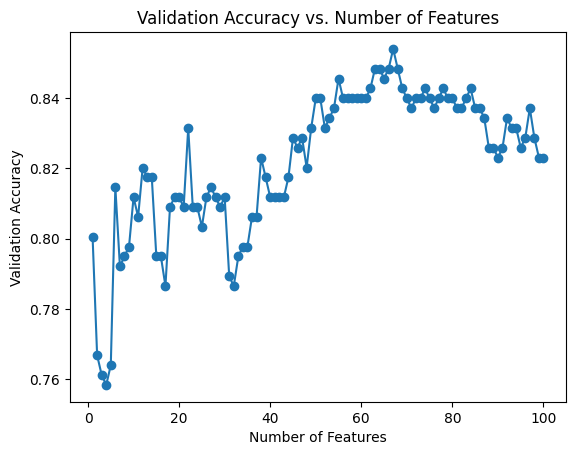

Optimal number of features: 67


In [170]:
for i in range(1,21):
    print(i)
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    knn_model = k_neigbhors(X_train, y_train, X_test, y_test)

    X_train_selected, X_test_selected = find_best_num_features(X_train, y_train, X_test, y_test, knn_model)
    X_train_selected
    SHAP_Feature_selection.append(X_train_selected)

## Selection

In [172]:

from collections import Counter
# Using list comprehension to flatten the list
features = [item for sublist in SHAP_Feature_selection for item in sublist]
# Count occurrences of each feature
feature_counts = Counter(features)

print(feature_counts)


Counter({'FractionCSP3': 33, 'fr_aldehyde': 30, 'PEOE_VSA3': 25, 'SlogP_VSA4': 25, 'PEOE_VSA2': 24, 'SMR_VSA4': 23, 'SMR_VSA7': 23, 'MaxAbsEStateIndex': 23, 'fr_NH2': 22, 'EState_VSA9': 22, 'NumSaturatedCarbocycles': 22, 'SMR_VSA5': 22, 'fr_ether': 22, 'EState_VSA8': 21, 'FpDensityMorgan1': 21, 'SMR_VSA6': 21, 'NumAliphaticCarbocycles': 20, 'MaxEStateIndex': 20, 'PEOE_VSA9': 20, 'EState_VSA3': 20, 'fr_NH1': 19, 'EState_VSA7': 19, 'PEOE_VSA7': 19, 'Chi1n': 19, 'Chi1v': 19, 'NumAromaticRings': 19, 'AvgIpc': 19, 'VSA_EState6': 18, 'EState_VSA2': 18, 'VSA_EState10': 18, 'fr_amide': 18, 'MinAbsPartialCharge': 18, 'Kappa3': 18, 'SPS': 18, 'SlogP_VSA6': 17, 'EState_VSA5': 17, 'SMR_VSA10': 17, 'VSA_EState4': 17, 'FpDensityMorgan2': 17, 'fr_C_O_noCOO': 17, 'fr_ester': 17, 'SlogP_VSA11': 17, 'PEOE_VSA5': 17, 'Chi2v': 16, 'PEOE_VSA11': 16, 'Chi0n': 16, 'FpDensityMorgan3': 16, 'fr_benzene': 16, 'EState_VSA6': 16, 'SlogP_VSA1': 16, 'SMR_VSA3': 16, 'Chi2n': 15, 'VSA_EState2': 15, 'NumValenceElectron

In [175]:
threshold = 21  # Minimum number of votes required
selected_features = [feature for feature, count in feature_counts.items() if count >= threshold]

print(len(selected_features))

16


In [132]:
SVM_feature_counts = feature_counts

In [144]:
SVM_feature_counts_NB = feature_counts 

### XGB feature names

In [42]:
XGB_feature_names_SHAP_20 = [feature for feature, count in feature_counts.items() if count >= 20]
XGB_feature_names_SHAP_17 = [feature for feature, count in feature_counts.items() if count >= 17]
XGB_feature_counts_SHAP = feature_counts

In [37]:
XGB_feature_names_SHAP_20

['BertzCT',
 'PEOE_VSA1',
 'HallKierAlpha',
 'BalabanJ',
 'PEOE_VSA6',
 'PEOE_VSA9',
 'MinAbsEStateIndex',
 'EState_VSA3',
 'VSA_EState5',
 'MaxPartialCharge',
 'VSA_EState8',
 'Kappa3',
 'EState_VSA4']

In [60]:
All_methods = XGB_feature_names_RF_18 + XGB_feature_names_SHAP_19 + XGB_feature_names_RFE_20 + feature_names_Lasso

In [61]:
feature_counts = Counter(All_methods)

print(feature_counts)

Counter({'HallKierAlpha': 3, 'PEOE_VSA1': 3, 'BertzCT': 3, 'PEOE_VSA9': 3, 'AvgIpc': 2, 'BalabanJ': 2, 'MaxPartialCharge': 2, 'EState_VSA3': 1, 'MinAbsEStateIndex': 1, 'MaxEStateIndex': 1, 'EState_VSA2': 1, 'HeavyAtomCount': 1, 'NumAromaticRings': 1})


In [64]:

selected_features = [feature for feature, count in feature_counts.items() if count >= 2]

print(len(selected_features))
print(selected_features)

7
['HallKierAlpha', 'PEOE_VSA1', 'BertzCT', 'PEOE_VSA9', 'AvgIpc', 'BalabanJ', 'MaxPartialCharge']


### Random forest features

In [69]:
RF_feature_names_SHAP_18 = [feature for feature, count in feature_counts.items() if count >= 18]
RF_feature_names_SHAP_19 = [feature for feature, count in feature_counts.items() if count >= 19]
RF_feature_counts_SHAP = feature_counts

In [69]:

selected_features = [feature for feature, count in feature_counts.items() if count >= 2]

print(len(selected_features))
print(selected_features)

47
['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA6', 'SlogP_VSA2', 'TPSA', 'EState_VSA3', 'VSA_EState5', 'VSA_EState7', 'VSA_EState8', 'NOCount', 'MolLogP', 'MolMR']


## Save Selected Features

In [81]:
selected_features = RF_feature_names_RF_19

In [176]:
selected_features

['fr_aldehyde',
 'PEOE_VSA2',
 'fr_NH2',
 'FractionCSP3',
 'PEOE_VSA3',
 'SlogP_VSA4',
 'EState_VSA8',
 'FpDensityMorgan1',
 'SMR_VSA4',
 'EState_VSA9',
 'SMR_VSA7',
 'SMR_VSA6',
 'NumSaturatedCarbocycles',
 'MaxAbsEStateIndex',
 'SMR_VSA5',
 'fr_ether']

In [177]:
#selected_features = list(X_train_selected.columns)
selected_features.append("Irritation")

# Convert to DataFrame
df_selected = df[selected_features]

# Export to Excel
df_selected.to_excel("Features/Rabbit_NB_SHAP_KNN.xlsx", index=False)